# Loading the dataset 

In [186]:
from keras.datasets import mnist
import plotly
import matplotlib
import torch
from matplotlib import pyplot
import torch
import numpy as np
from scipy.linalg import sqrtm
import torchvision.models as models
import matplotlib.pyplot as plt
import torch
import torch
import torch.nn as nn
import torch.optim as optim
import torch
from torchvision import datasets, transforms

import torch
import torch.nn as nn

In [187]:
(train_X, train_y), (test_X, test_y) = mnist.load_data()

# Sample Data

5


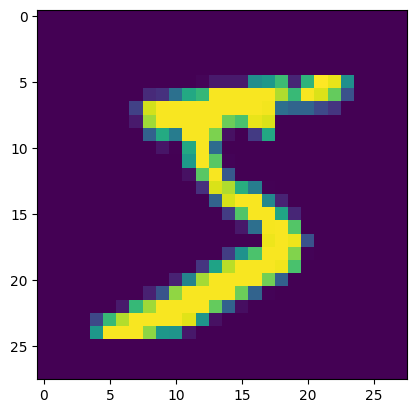

In [188]:
print(train_y[0])
pyplot.imshow(train_X[0])

# DATA Loader

In [189]:
batch_size = 512

transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
)

train_data = datasets.MNIST(root="data", train=True, download=True, transform=transform)

# train_data = torch.utils.data.Subset(train_data, range(30000))

dataloader = torch.utils.data.DataLoader(
    train_data, batch_size=batch_size, shuffle=True
)

In [190]:
z_dim = 64
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(z_dim, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(True),
            nn.Linear(512, 128 * 7 * 7),
            nn.BatchNorm1d(128 * 7 * 7),
            nn.ReLU(True),
        )
        self.conv = nn.Sequential(
            nn.Conv2d(128, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.PixelShuffle(2),
            nn.Conv2d(8, 8, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.PixelShuffle(2),
            nn.Conv2d(2, 1, kernel_size=3, stride=1, padding=1),
        )

    def forward(self, z):
        z = self.fc(z)
        z = z.view(-1, 128, 7, 7)
        out = self.conv(z)
        return out


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv_layer = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Flatten(),
        )
        self.network = nn.Sequential(
            self.conv_layer,
            nn.Linear(64 * 7 * 7, 512),
            nn.Linear(512, 1),
            nn.Sigmoid(),
        )

    def forward(self, img):
        out = self.network(img)
        return out

In [191]:


def generate_and_display_samples(generator, num_samples=100, rows=10, cols=10):
    generator.eval()
    with torch.no_grad():
        noise = torch.randn(num_samples, z_dim).to(device)
        fake_images = generator(noise)
        fake_images = fake_images.cpu().detach().numpy()

        fig, axs = plt.subplots(rows, cols, figsize=(10, 10))
        axs = axs.ravel()

        for i in range(num_samples):
            fake_image = fake_images[i].reshape(28, 28) 
            axs[i].imshow(fake_image[0], cmap="gray")
            axs[i].axis("off")

        plt.subplots_adjust(wspace=0.1, hspace=0.1)
        plt.show()

    generator.train()
    return fake_images



In [192]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [193]:

lr = 0.0001

generator = Generator()
discriminator = Discriminator()
generator = generator.to(device)
discriminator = discriminator.to(device)
criterion = nn.BCELoss()
d_optimizer = optim.Adam(discriminator.parameters(), lr=lr)
g_optimizer = optim.Adam(generator.parameters(), lr=lr)

In [194]:
def pretty_progress(epoch, num_epochs, batch, num_batches, d_loss, g_loss):
    filled_length = int(50 * batch // num_batches)
    bar = "#" * filled_length + "-" * (50 - filled_length)
    progress = (batch / num_batches) * 100
    print(
        f"\rEpoch [{epoch+1}/{num_epochs}] | Batch [{batch+1}/{num_batches}] | "
        f"d_loss: {d_loss.item():.4f} | g_loss: {g_loss.item():.4f} | "
        f"Progress: [{bar}] {progress:.1f}%",
        end="",
    )

In [195]:
# calculate the FID score:
# using the https://github.com/mseitzer/pytorch-fid repo:
from pytorch_fid import fid_score
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm
import os


In [196]:
def incept_and_extract(inception_model, input_data):
    inception_model.eval()
    with torch.no_grad():
        features = inception_model(input_data.to(device))
    return features


def torch_cov(data, rowvar=False):
    if rowvar:
        data = data.t()
    mean = torch.mean(data, 0)
    n = data.size(0) - 1
    data = data - mean.unsqueeze(0)
    return (data.t() @ data) / n


def matrix_sqrt(matrix):
    U, S, V = torch.linalg.svd(matrix)
    return U @ torch.diag(torch.sqrt(S)) @ V.t()


def calculate_fid(inception_model, real_images, generated_images):
    real_features = incept_and_extract(inception_model, real_images.to(device))
    gen_features = incept_and_extract(inception_model, generated_images.to(device))
    mu_real, sigma_real = torch.mean(real_features, 0), torch_cov(real_features)
    mu_gen, sigma_gen = torch.mean(gen_features, 0), torch_cov(gen_features)
    ssdiff = torch.sum((mu_real - mu_gen) ** 2)
    covmean = matrix_sqrt(sigma_real @ sigma_gen)
    fid = ssdiff + torch.trace(sigma_real + sigma_gen - 2 * covmean)
    return fid.item()

In [197]:

def real_labels(size):
    return torch.ones(size, 1).to(device)


def fake_labels(size):
    return torch.zeros(size, 1).to(device)


def gen_fake_images(generator, gen_samples):
    noise = torch.randn(gen_samples, z_dim).to(device)
    fake_images = generator(noise)
    return fake_images

def some_eval(inception_model, data_batchs=1):
    real_data = []
    for x, y in dataloader:
        real_data.append(x)
        break
    real_data = real_data[0]
    gen_samples = len(real_data)
    generated_images = gen_fake_images(generator, gen_samples).to("cuda")
    fid_score = calculate_fid(inception_model, real_data, generated_images)
    return fid_score


Epoch 0
Epoch [1/150] | Batch [59/59] | d_loss: 0.0151 | g_loss: 6.0026 | Progress: [#################################################-] 98.3%Evaluation happens in this epoch
FID SCORE :  0.9510539174079895


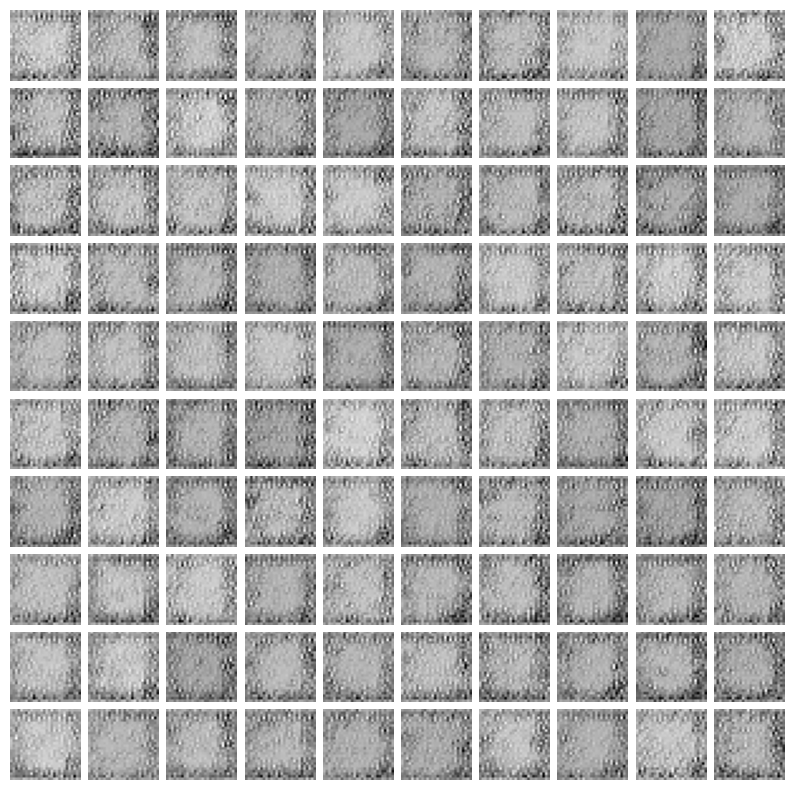


Epoch 1
Epoch [2/150] | Batch [59/59] | d_loss: 0.0015 | g_loss: 7.8635 | Progress: [#################################################-] 98.3%
Epoch 2
Epoch [3/150] | Batch [59/59] | d_loss: 0.0009 | g_loss: 8.7940 | Progress: [#################################################-] 98.3%
Epoch 3
Epoch [4/150] | Batch [59/59] | d_loss: 0.0009 | g_loss: 10.1155 | Progress: [#################################################-] 98.3%
Epoch 4
Epoch [5/150] | Batch [59/59] | d_loss: 0.0041 | g_loss: 10.5778 | Progress: [#################################################-] 98.3%
Epoch 5
Epoch [6/150] | Batch [59/59] | d_loss: 0.0018 | g_loss: 10.3401 | Progress: [#################################################-] 98.3%
Epoch 6
Epoch [7/150] | Batch [59/59] | d_loss: 0.0087 | g_loss: 9.4608 | Progress: [#################################################-] 98.3%%
Epoch 7
Epoch [8/150] | Batch [59/59] | d_loss: 0.0092 | g_loss: 7.6583 | Progress: [#################################################-] 

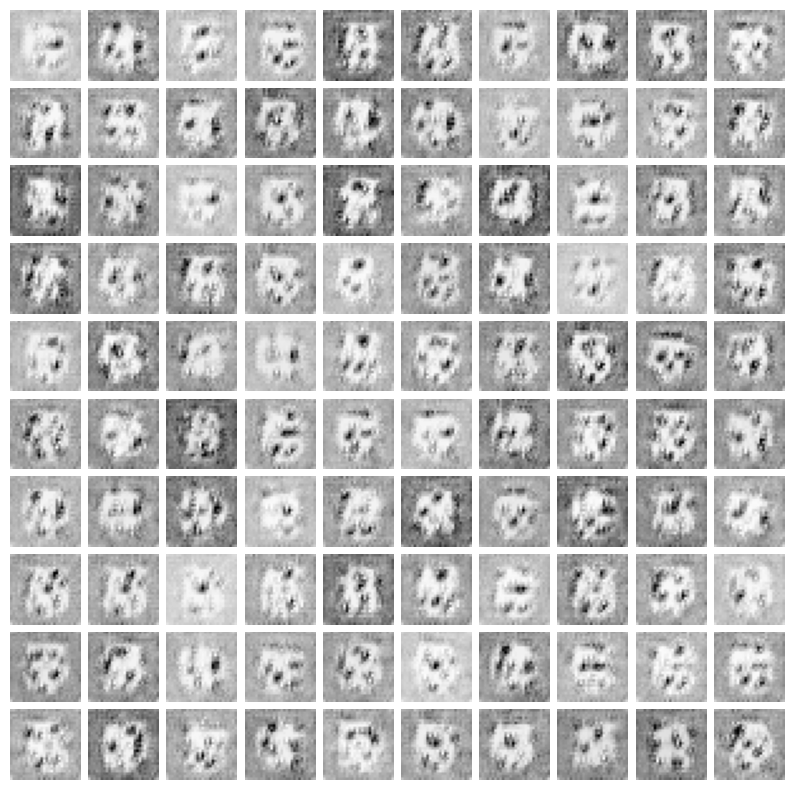


Epoch 11
Epoch [12/150] | Batch [59/59] | d_loss: 0.0021 | g_loss: 9.7862 | Progress: [#################################################-] 98.3%%
Epoch 12
Epoch [13/150] | Batch [59/59] | d_loss: 0.0004 | g_loss: 7.4657 | Progress: [#################################################-] 98.3%%
Epoch 13
Epoch [14/150] | Batch [59/59] | d_loss: 0.0024 | g_loss: 6.5434 | Progress: [#################################################-] 98.3%%
Epoch 14
Epoch [15/150] | Batch [59/59] | d_loss: 0.0014 | g_loss: 7.4260 | Progress: [#################################################-] 98.3%%
Epoch 15
Epoch [16/150] | Batch [59/59] | d_loss: 0.0070 | g_loss: 11.8890 | Progress: [#################################################-] 98.3%
Epoch 16
Epoch [17/150] | Batch [59/59] | d_loss: 0.0003 | g_loss: 9.9341 | Progress: [#################################################-] 98.3%%
Epoch 17
Epoch [18/150] | Batch [59/59] | d_loss: 0.0028 | g_loss: 12.5023 | Progress: [###################################

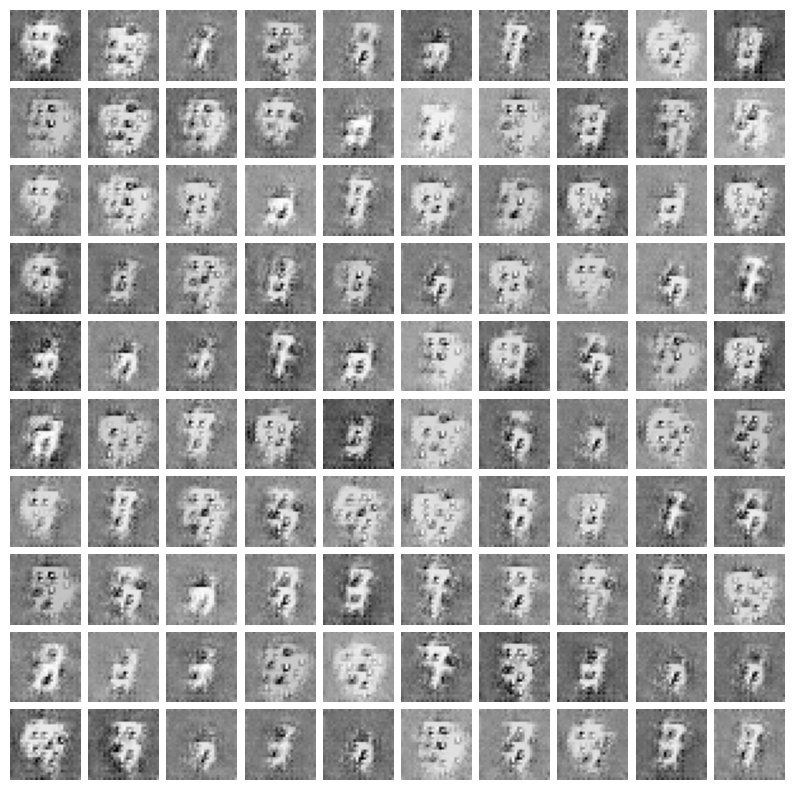


Epoch 21
Epoch [22/150] | Batch [59/59] | d_loss: 0.0010 | g_loss: 11.3213 | Progress: [#################################################-] 98.3%
Epoch 22
Epoch [23/150] | Batch [59/59] | d_loss: 0.0047 | g_loss: 9.3580 | Progress: [#################################################-] 98.3%%
Epoch 23
Epoch [24/150] | Batch [59/59] | d_loss: 0.0031 | g_loss: 8.8835 | Progress: [#################################################-] 98.3%%
Epoch 24
Epoch [25/150] | Batch [59/59] | d_loss: 0.0002 | g_loss: 9.7235 | Progress: [#################################################-] 98.3%%
Epoch 25
Epoch [26/150] | Batch [59/59] | d_loss: 0.0073 | g_loss: 8.1502 | Progress: [#################################################-] 98.3%%
Epoch 26
Epoch [27/150] | Batch [59/59] | d_loss: 0.0012 | g_loss: 8.9994 | Progress: [#################################################-] 98.3%%
Epoch 27
Epoch [28/150] | Batch [59/59] | d_loss: 0.0030 | g_loss: 10.2954 | Progress: [###################################

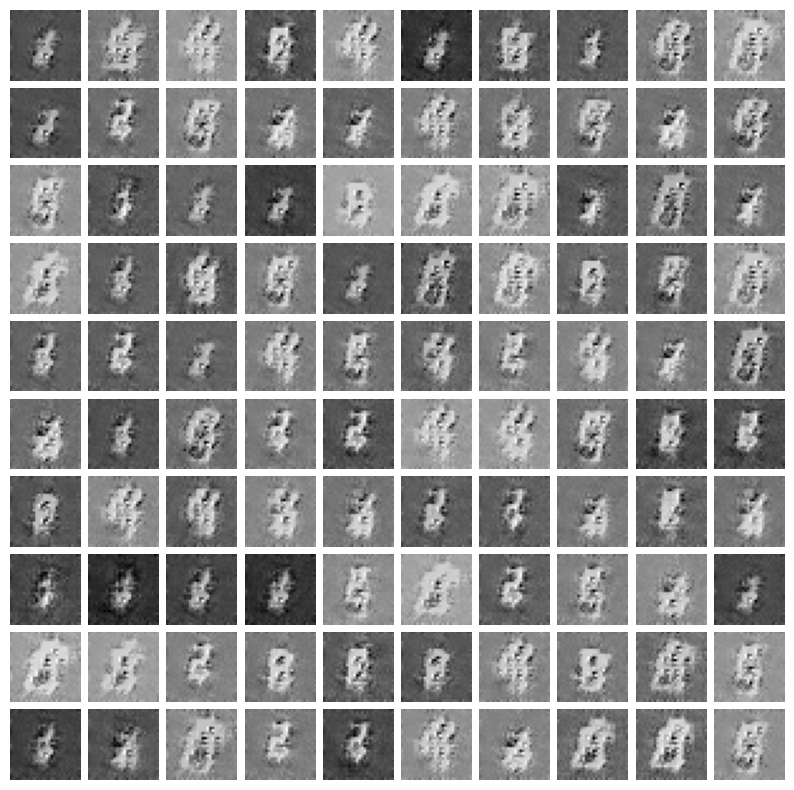


Epoch 31
Epoch [32/150] | Batch [59/59] | d_loss: 0.0198 | g_loss: 9.6256 | Progress: [#################################################-] 98.3%%
Epoch 32
Epoch [33/150] | Batch [59/59] | d_loss: 0.0108 | g_loss: 9.0569 | Progress: [#################################################-] 98.3%%
Epoch 33
Epoch [34/150] | Batch [59/59] | d_loss: 0.0472 | g_loss: 7.3329 | Progress: [#################################################-] 98.3%
Epoch 34
Epoch [35/150] | Batch [59/59] | d_loss: 0.0066 | g_loss: 7.1414 | Progress: [#################################################-] 98.3%
Epoch 35
Epoch [36/150] | Batch [59/59] | d_loss: 0.0165 | g_loss: 6.4639 | Progress: [#################################################-] 98.3%
Epoch 36
Epoch [37/150] | Batch [59/59] | d_loss: 0.0167 | g_loss: 5.9038 | Progress: [#################################################-] 98.3%
Epoch 37
Epoch [38/150] | Batch [59/59] | d_loss: 0.0297 | g_loss: 5.7285 | Progress: [########################################

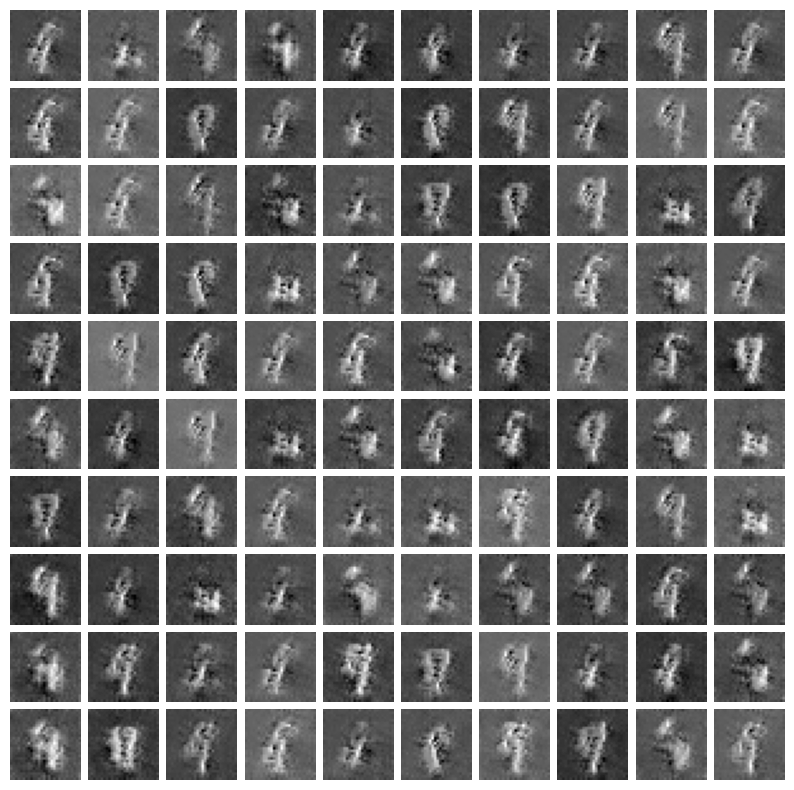


Epoch 41
Epoch [42/150] | Batch [59/59] | d_loss: 0.0429 | g_loss: 5.2997 | Progress: [#################################################-] 98.3%
Epoch 42
Epoch [43/150] | Batch [59/59] | d_loss: 0.0515 | g_loss: 6.3185 | Progress: [#################################################-] 98.3%
Epoch 43
Epoch [44/150] | Batch [59/59] | d_loss: 0.0676 | g_loss: 5.3475 | Progress: [#################################################-] 98.3%
Epoch 44
Epoch [45/150] | Batch [59/59] | d_loss: 0.3177 | g_loss: 3.1112 | Progress: [#################################################-] 98.3%%
Epoch 45
Epoch [46/150] | Batch [59/59] | d_loss: 0.1504 | g_loss: 6.5707 | Progress: [#################################################-] 98.3%
Epoch 46
Epoch [47/150] | Batch [59/59] | d_loss: 0.1075 | g_loss: 4.8049 | Progress: [#################################################-] 98.3%
Epoch 47
Epoch [48/150] | Batch [59/59] | d_loss: 0.0731 | g_loss: 4.7275 | Progress: [#########################################

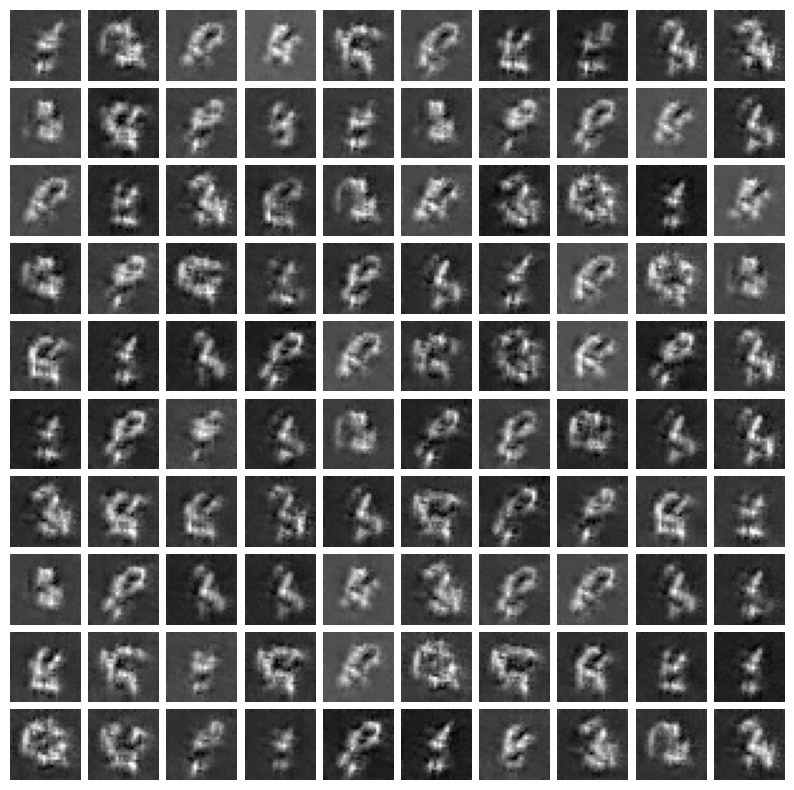


Epoch 51
Epoch [52/150] | Batch [59/59] | d_loss: 0.0407 | g_loss: 5.7001 | Progress: [#################################################-] 98.3%
Epoch 52
Epoch [53/150] | Batch [59/59] | d_loss: 0.0769 | g_loss: 6.0922 | Progress: [#################################################-] 98.3%
Epoch 53
Epoch [54/150] | Batch [59/59] | d_loss: 0.1468 | g_loss: 6.2805 | Progress: [#################################################-] 98.3%
Epoch 54
Epoch [55/150] | Batch [59/59] | d_loss: 0.1399 | g_loss: 4.2920 | Progress: [#################################################-] 98.3%
Epoch 55
Epoch [56/150] | Batch [59/59] | d_loss: 0.0465 | g_loss: 6.2301 | Progress: [#################################################-] 98.3%%
Epoch 56
Epoch [57/150] | Batch [59/59] | d_loss: 0.1492 | g_loss: 5.4787 | Progress: [#################################################-] 98.3%
Epoch 57
Epoch [58/150] | Batch [59/59] | d_loss: 0.0890 | g_loss: 5.0770 | Progress: [#########################################

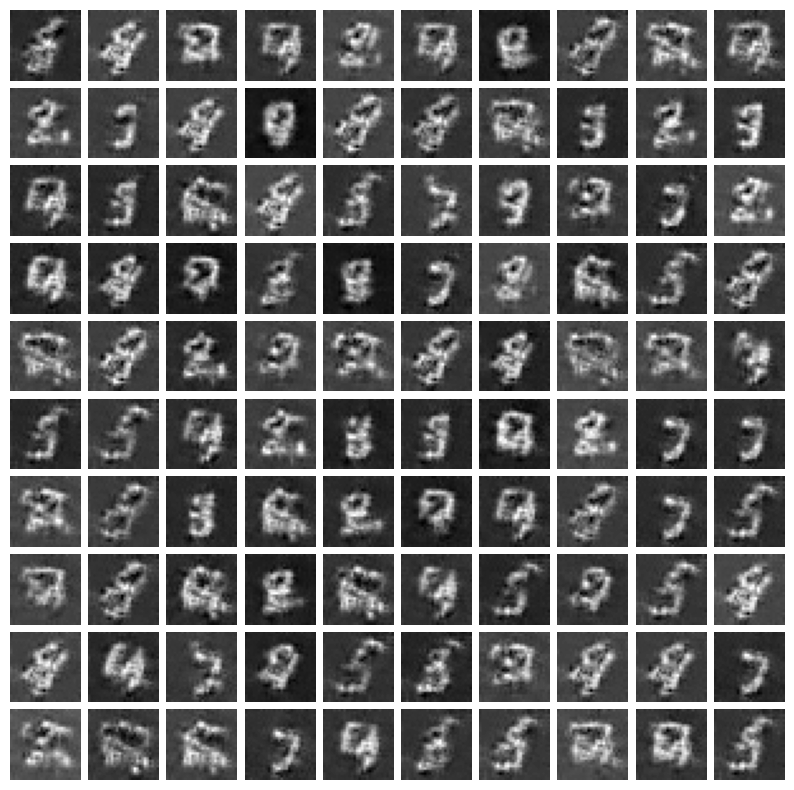


Epoch 61
Epoch [62/150] | Batch [59/59] | d_loss: 0.1463 | g_loss: 4.5020 | Progress: [#################################################-] 98.3%
Epoch 62
Epoch [63/150] | Batch [59/59] | d_loss: 0.1096 | g_loss: 4.5247 | Progress: [#################################################-] 98.3%
Epoch 63
Epoch [64/150] | Batch [59/59] | d_loss: 0.1354 | g_loss: 4.5728 | Progress: [#################################################-] 98.3%
Epoch 64
Epoch [65/150] | Batch [59/59] | d_loss: 0.1535 | g_loss: 4.1154 | Progress: [#################################################-] 98.3%
Epoch 65
Epoch [66/150] | Batch [59/59] | d_loss: 0.1132 | g_loss: 5.4709 | Progress: [#################################################-] 98.3%
Epoch 66
Epoch [67/150] | Batch [59/59] | d_loss: 0.0919 | g_loss: 5.8469 | Progress: [#################################################-] 98.3%
Epoch 67
Epoch [68/150] | Batch [59/59] | d_loss: 0.1335 | g_loss: 5.0860 | Progress: [##########################################

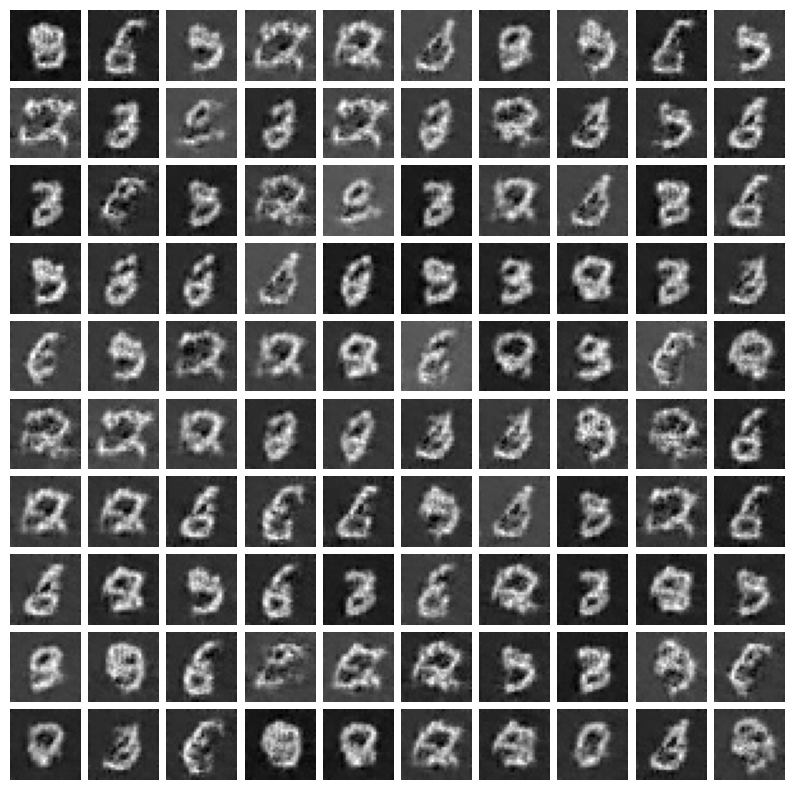


Epoch 71
Epoch [72/150] | Batch [59/59] | d_loss: 0.2172 | g_loss: 3.5580 | Progress: [#################################################-] 98.3%
Epoch 72
Epoch [73/150] | Batch [59/59] | d_loss: 0.1718 | g_loss: 4.1281 | Progress: [#################################################-] 98.3%
Epoch 73
Epoch [74/150] | Batch [59/59] | d_loss: 0.0850 | g_loss: 4.9787 | Progress: [#################################################-] 98.3%
Epoch 74
Epoch [75/150] | Batch [59/59] | d_loss: 0.1033 | g_loss: 4.4733 | Progress: [#################################################-] 98.3%
Epoch 75
Epoch [76/150] | Batch [59/59] | d_loss: 0.1134 | g_loss: 4.3654 | Progress: [#################################################-] 98.3%
Epoch 76
Epoch [77/150] | Batch [59/59] | d_loss: 0.1427 | g_loss: 4.6594 | Progress: [#################################################-] 98.3%
Epoch 77
Epoch [78/150] | Batch [59/59] | d_loss: 0.2200 | g_loss: 3.5392 | Progress: [##########################################

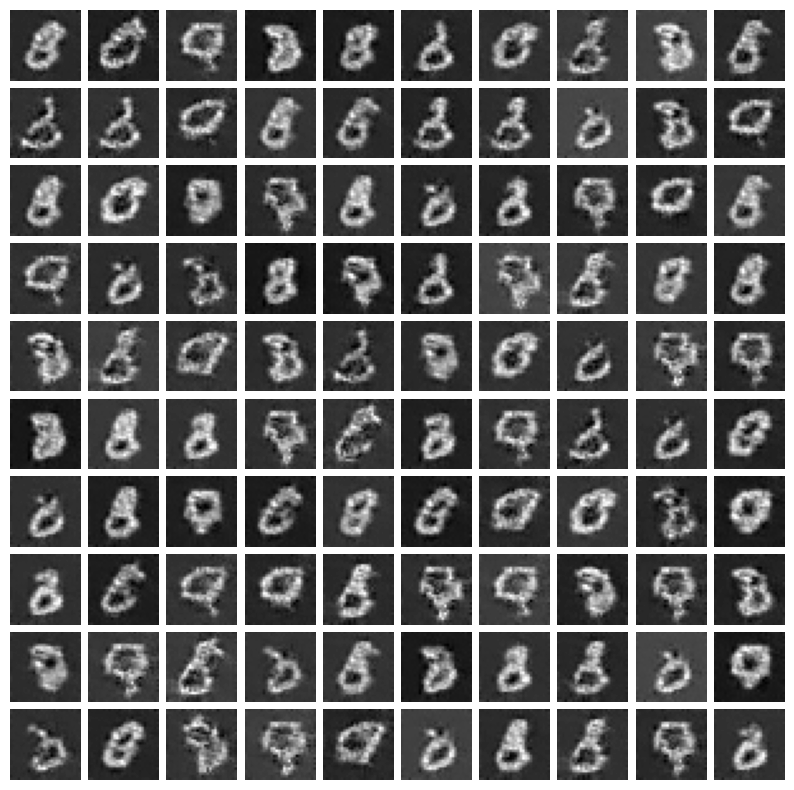


Epoch 81
Epoch [82/150] | Batch [59/59] | d_loss: 0.1396 | g_loss: 5.0709 | Progress: [#################################################-] 98.3%
Epoch 82
Epoch [83/150] | Batch [59/59] | d_loss: 0.0712 | g_loss: 4.1550 | Progress: [#################################################-] 98.3%
Epoch 83
Epoch [84/150] | Batch [59/59] | d_loss: 3.6394 | g_loss: 19.9220 | Progress: [#################################################-] 98.3%
Epoch 84
Epoch [85/150] | Batch [59/59] | d_loss: 0.1737 | g_loss: 4.1786 | Progress: [#################################################-] 98.3%%
Epoch 85
Epoch [86/150] | Batch [59/59] | d_loss: 0.1751 | g_loss: 4.0134 | Progress: [#################################################-] 98.3%
Epoch 86
Epoch [87/150] | Batch [59/59] | d_loss: 0.1643 | g_loss: 3.6556 | Progress: [#################################################-] 98.3%
Epoch 87
Epoch [88/150] | Batch [59/59] | d_loss: 0.1139 | g_loss: 4.7326 | Progress: [########################################

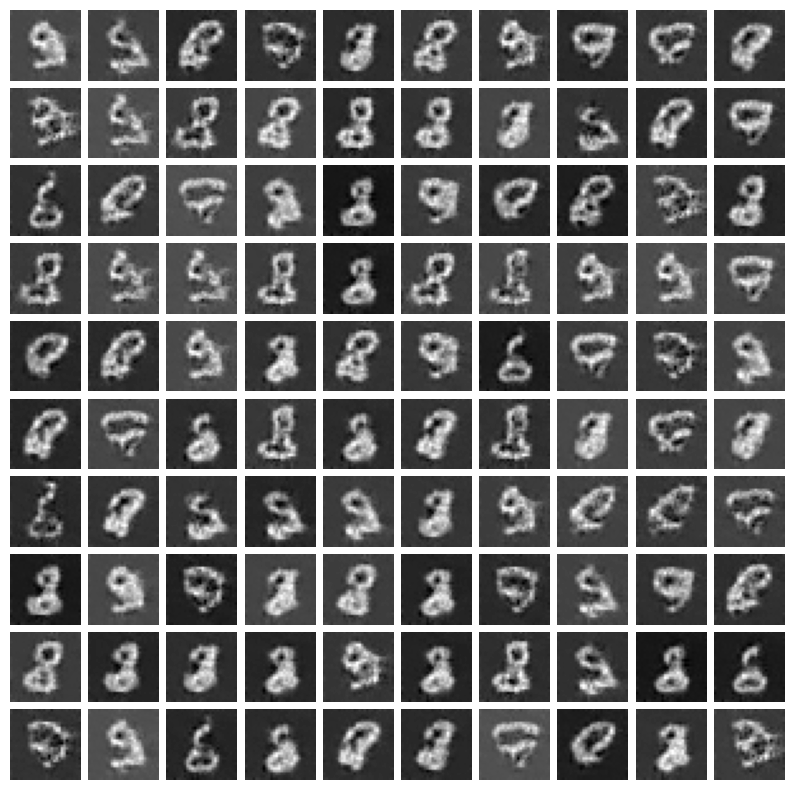


Epoch 91
Epoch [92/150] | Batch [59/59] | d_loss: 0.1108 | g_loss: 4.4392 | Progress: [#################################################-] 98.3%
Epoch 92
Epoch [93/150] | Batch [59/59] | d_loss: 0.1339 | g_loss: 5.4469 | Progress: [#################################################-] 98.3%
Epoch 93
Epoch [94/150] | Batch [59/59] | d_loss: 0.1329 | g_loss: 2.7959 | Progress: [#################################################-] 98.3%%
Epoch 94
Epoch [95/150] | Batch [59/59] | d_loss: 0.1988 | g_loss: 4.2554 | Progress: [#################################################-] 98.3%
Epoch 95
Epoch [96/150] | Batch [59/59] | d_loss: 0.1215 | g_loss: 5.2969 | Progress: [#################################################-] 98.3%
Epoch 96
Epoch [97/150] | Batch [59/59] | d_loss: 0.1378 | g_loss: 4.5157 | Progress: [#################################################-] 98.3%
Epoch 97
Epoch [98/150] | Batch [59/59] | d_loss: 0.1106 | g_loss: 5.3326 | Progress: [#########################################

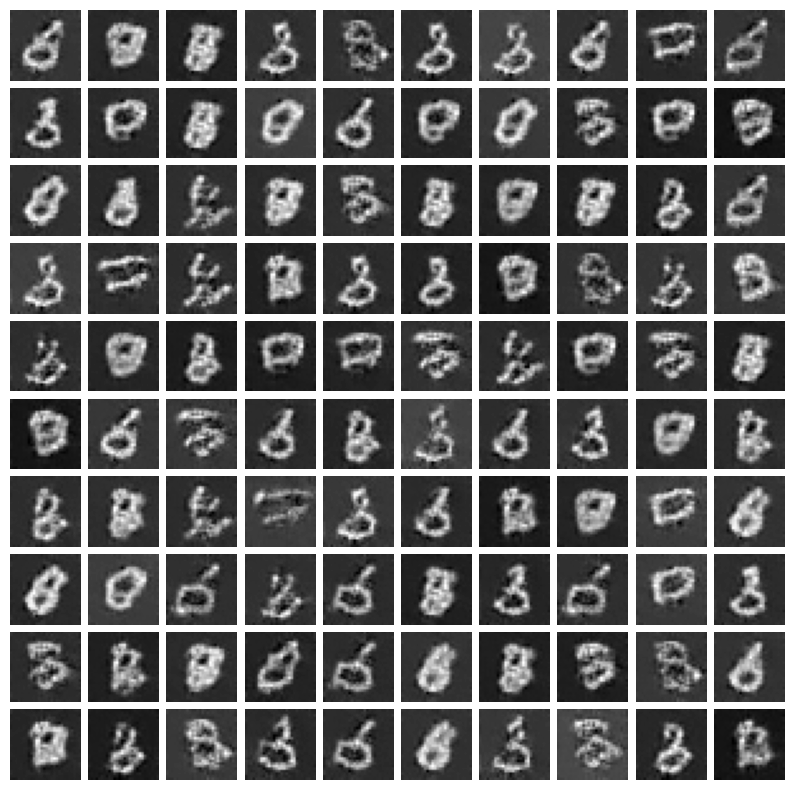


Epoch 101
Epoch [102/150] | Batch [59/59] | d_loss: 0.0903 | g_loss: 4.7384 | Progress: [#################################################-] 98.3%
Epoch 102
Epoch [103/150] | Batch [59/59] | d_loss: 0.1514 | g_loss: 3.2848 | Progress: [#################################################-] 98.3%
Epoch 103
Epoch [104/150] | Batch [59/59] | d_loss: 0.0998 | g_loss: 5.4761 | Progress: [#################################################-] 98.3%
Epoch 104
Epoch [105/150] | Batch [59/59] | d_loss: 1.1754 | g_loss: 7.3398 | Progress: [#################################################-] 98.3%%
Epoch 105
Epoch [106/150] | Batch [59/59] | d_loss: 0.2126 | g_loss: 4.9643 | Progress: [#################################################-] 98.3%%
Epoch 106
Epoch [107/150] | Batch [59/59] | d_loss: 0.1047 | g_loss: 4.7428 | Progress: [#################################################-] 98.3%
Epoch 107
Epoch [108/150] | Batch [59/59] | d_loss: 0.1321 | g_loss: 4.8564 | Progress: [##########################

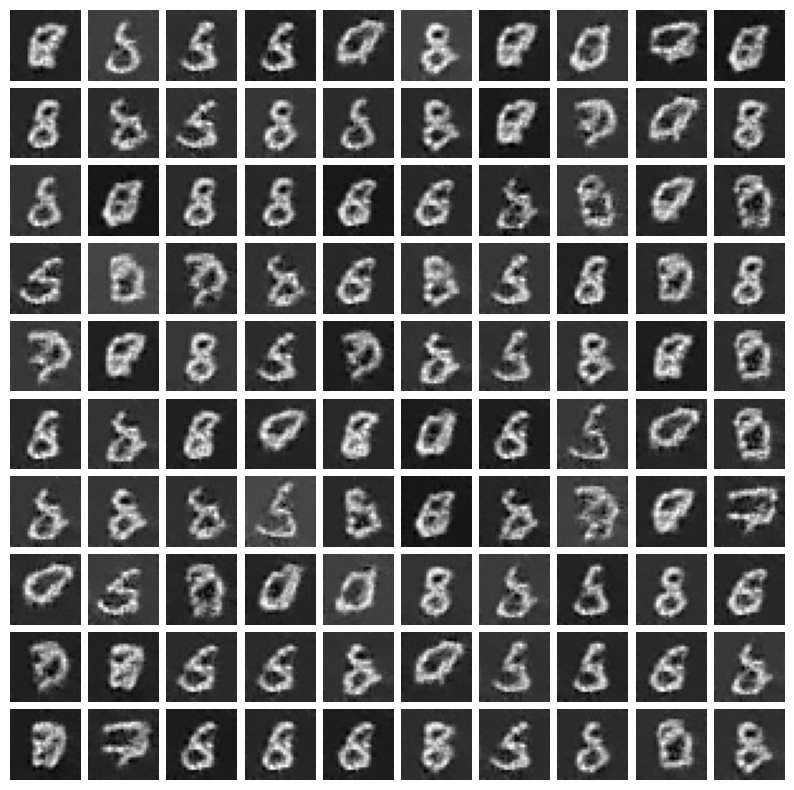


Epoch 111
Epoch [112/150] | Batch [59/59] | d_loss: 0.1228 | g_loss: 3.7882 | Progress: [#################################################-] 98.3%
Epoch 112
Epoch [113/150] | Batch [59/59] | d_loss: 0.1848 | g_loss: 3.2487 | Progress: [#################################################-] 98.3%
Epoch 113
Epoch [114/150] | Batch [59/59] | d_loss: 0.1178 | g_loss: 4.0940 | Progress: [#################################################-] 98.3%
Epoch 114
Epoch [115/150] | Batch [59/59] | d_loss: 0.1163 | g_loss: 3.0916 | Progress: [#################################################-] 98.3%
Epoch 115
Epoch [116/150] | Batch [59/59] | d_loss: 0.1142 | g_loss: 3.8407 | Progress: [#################################################-] 98.3%
Epoch 116
Epoch [117/150] | Batch [59/59] | d_loss: 0.1231 | g_loss: 7.1500 | Progress: [#################################################-] 98.3%
Epoch 117
Epoch [118/150] | Batch [59/59] | d_loss: 0.0604 | g_loss: 5.4916 | Progress: [############################

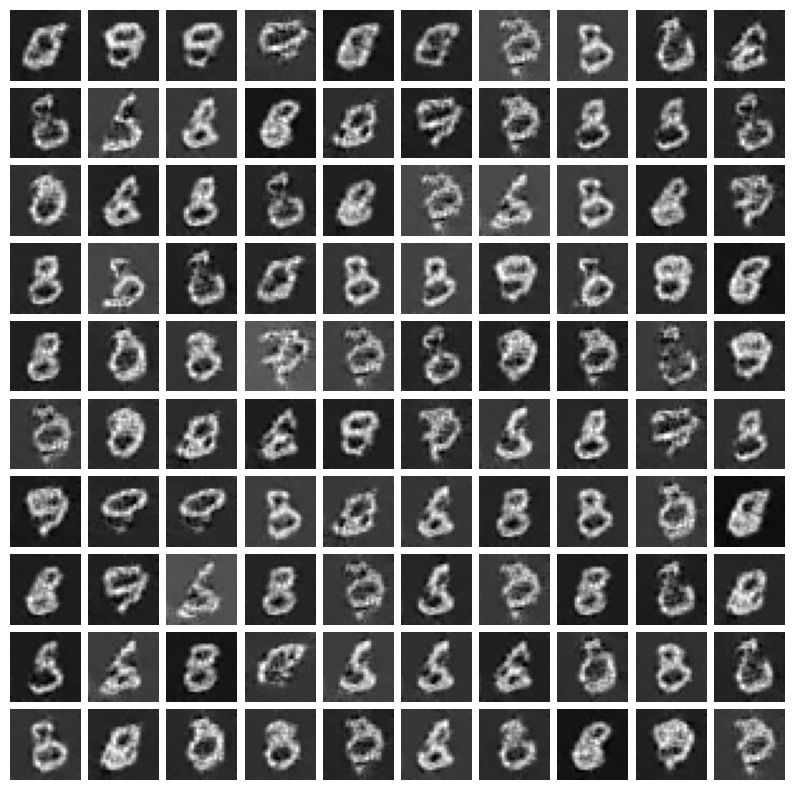


Epoch 121
Epoch [122/150] | Batch [59/59] | d_loss: 4.6133 | g_loss: 19.0180 | Progress: [#################################################-] 98.3%
Epoch 122
Epoch [123/150] | Batch [59/59] | d_loss: 0.1233 | g_loss: 5.0883 | Progress: [#################################################-] 98.3%%
Epoch 123
Epoch [124/150] | Batch [59/59] | d_loss: 0.1573 | g_loss: 4.3779 | Progress: [#################################################-] 98.3%
Epoch 124
Epoch [125/150] | Batch [59/59] | d_loss: 0.1060 | g_loss: 4.4770 | Progress: [#################################################-] 98.3%
Epoch 125
Epoch [126/150] | Batch [59/59] | d_loss: 0.1322 | g_loss: 4.4371 | Progress: [#################################################-] 98.3%
Epoch 126
Epoch [127/150] | Batch [59/59] | d_loss: 0.1626 | g_loss: 3.0776 | Progress: [#################################################-] 98.3%
Epoch 127
Epoch [128/150] | Batch [59/59] | d_loss: 0.1136 | g_loss: 2.4843 | Progress: [##########################

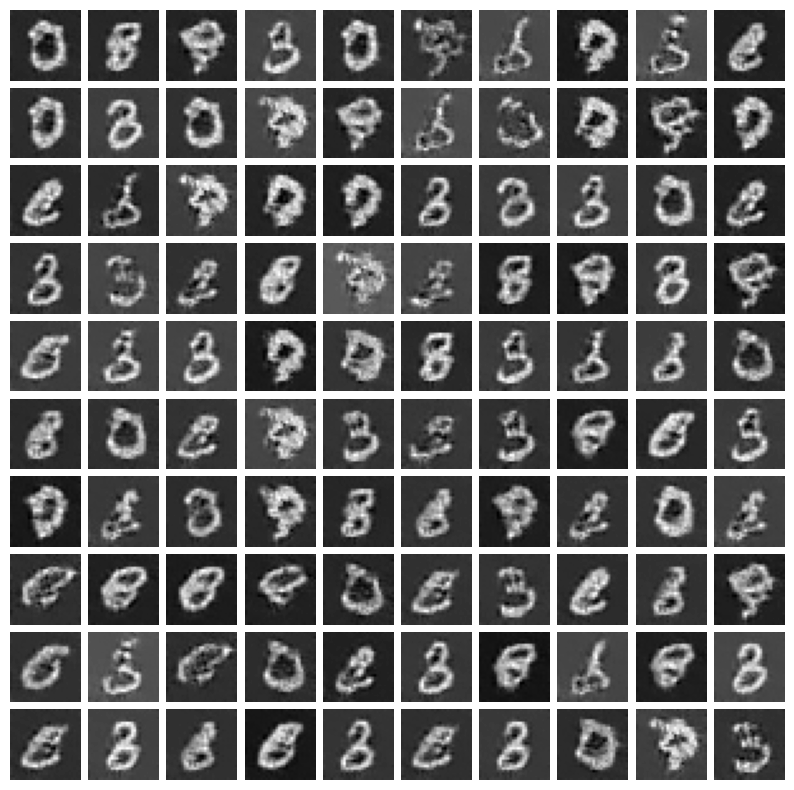


Epoch 131
Epoch [132/150] | Batch [59/59] | d_loss: 0.0615 | g_loss: 4.8405 | Progress: [#################################################-] 98.3%
Epoch 132
Epoch [133/150] | Batch [59/59] | d_loss: 0.1700 | g_loss: 5.3056 | Progress: [#################################################-] 98.3%
Epoch 133
Epoch [134/150] | Batch [59/59] | d_loss: 0.1219 | g_loss: 2.9329 | Progress: [#################################################-] 98.3%
Epoch 134
Epoch [135/150] | Batch [59/59] | d_loss: 0.1593 | g_loss: 6.3109 | Progress: [#################################################-] 98.3%%
Epoch 135
Epoch [136/150] | Batch [59/59] | d_loss: 0.1413 | g_loss: 4.6578 | Progress: [#################################################-] 98.3%
Epoch 136
Epoch [137/150] | Batch [59/59] | d_loss: 0.1885 | g_loss: 4.8744 | Progress: [#################################################-] 98.3%
Epoch 137
Epoch [138/150] | Batch [59/59] | d_loss: 0.1343 | g_loss: 4.1168 | Progress: [###########################

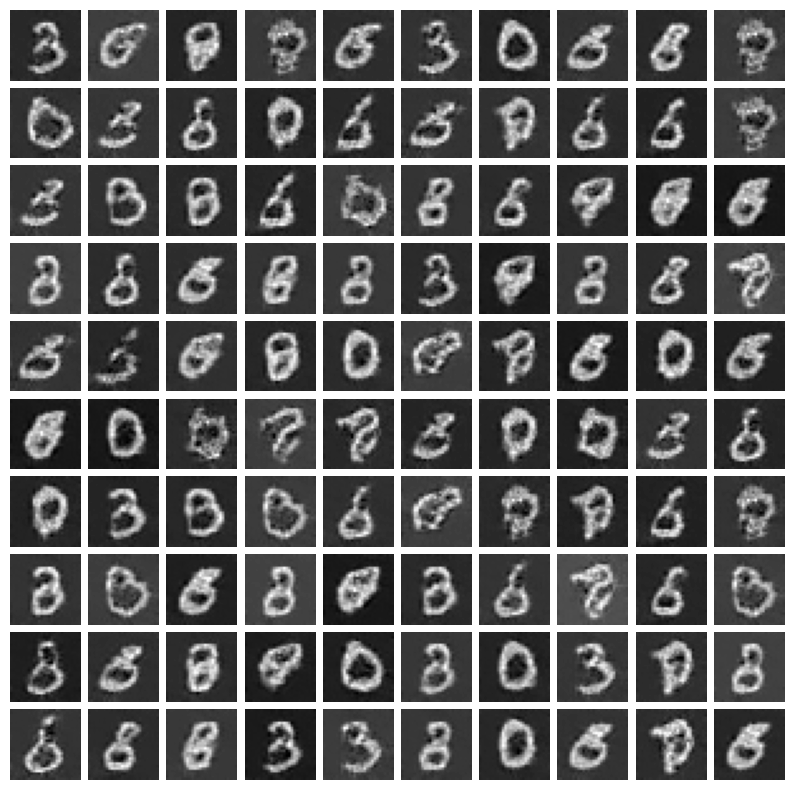


Epoch 141
Epoch [142/150] | Batch [59/59] | d_loss: 0.1234 | g_loss: 4.4812 | Progress: [#################################################-] 98.3%
Epoch 142
Epoch [143/150] | Batch [59/59] | d_loss: 0.0868 | g_loss: 4.1194 | Progress: [#################################################-] 98.3%
Epoch 143
Epoch [144/150] | Batch [59/59] | d_loss: 0.8434 | g_loss: 3.5938 | Progress: [#################################################-] 98.3%%
Epoch 144
Epoch [145/150] | Batch [59/59] | d_loss: 0.1244 | g_loss: 4.5279 | Progress: [#################################################-] 98.3%
Epoch 145
Epoch [146/150] | Batch [59/59] | d_loss: 0.1300 | g_loss: 4.3869 | Progress: [#################################################-] 98.3%
Epoch 146
Epoch [147/150] | Batch [59/59] | d_loss: 0.0991 | g_loss: 4.1485 | Progress: [#################################################-] 98.3%
Epoch 147
Epoch [148/150] | Batch [59/59] | d_loss: 0.1277 | g_loss: 4.1784 | Progress: [###########################

In [ ]:
image_size = 28 * 28
batch_size = 512
num_epochs = 150
start = 0
end = num_epochs
step = 10
evaluation_steps = list(range(start, end + 1, step))
training_meta_data = []
fid_scores = []
mid_train_generations = []
d_optimizer = optim.Adam(discriminator.parameters(), lr=lr)
g_optimizer = optim.Adam(generator.parameters(), lr=lr)
for epoch in range(num_epochs):
    meta_data = {}
    print("Epoch", epoch)
    for batch, (real_images, _) in enumerate(dataloader):
        real_images = real_images.view(-1, 1, 28, 28).to(device)
        batch_size = real_images.size(0)
        d_optimizer.zero_grad()
        real_outputs = discriminator(real_images)

        z = torch.randn(batch_size, z_dim).to(device)
        fake_images = generator(z)
        fake_outputs = discriminator(fake_images.detach())
        d_loss_real = criterion(
            discriminator(real_images), torch.ones(batch_size, 1).to(device)
        )
        d_loss_fake = criterion(
            discriminator(fake_images.detach()), torch.zeros(batch_size, 1).to(device)
        )
        d_loss = d_loss_real + d_loss_fake
        d_loss.backward()
        d_optimizer.step()

        g_optimizer.zero_grad()
        z = torch.randn(batch_size, z_dim).to(device)
        fake_images = generator(z)
        outputs = discriminator(fake_images)
        g_loss = criterion(outputs, real_labels(batch_size))
        g_loss.backward()
        g_optimizer.step()
        meta_data["d_loss"] = d_loss
        meta_data["g_loss"] = g_loss
        training_meta_data.append(meta_data)
        pretty_progress(epoch, num_epochs, batch, len(dataloader), d_loss, g_loss)

    if epoch in evaluation_steps:
        print("Evaluation happens in this epoch")
        fid_score = some_eval(discriminator, generator)
        meta_data["fid_score"] = fid_score
        print("FID SCORE : ", fid_score)
        fid_scores.append(fid_score)
        a = generate_and_display_samples(generator)
        mid_train_generations.append(a)
    print()

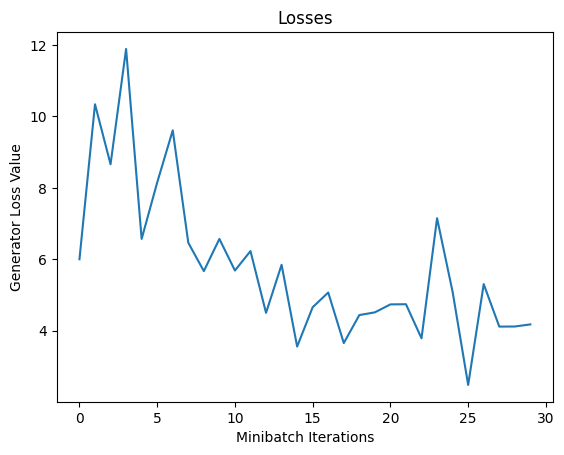

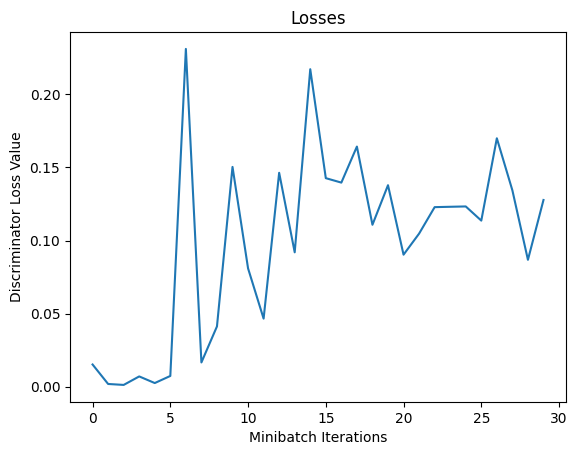

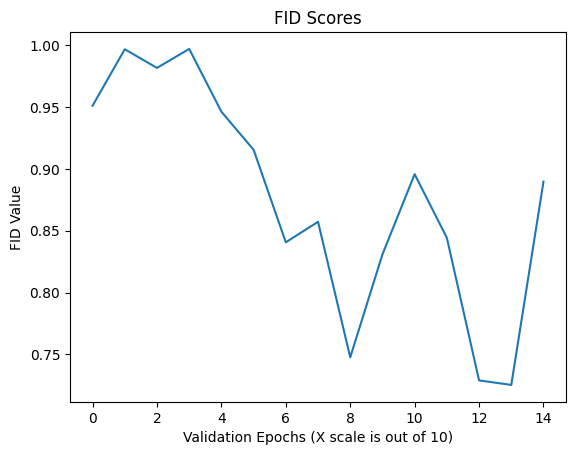

In [ ]:
import matplotlib.pyplot as plt

gen_loss = plt
# Example data

gen_loss.plot(list(map(lambda x: x["g_loss"].item(), training_meta_data[::300])))
gen_loss.title("Losses")
gen_loss.xlabel("Minibatch Iterations")
gen_loss.ylabel("Generator Loss Value")
gen_loss.show()

disc_loss = plt
# Example data

disc_loss.plot(list(map(lambda x: x["d_loss"].item(), training_meta_data[::300])))
disc_loss.title("Losses")
disc_loss.xlabel("Minibatch Iterations")
disc_loss.ylabel("Discriminator Loss Value")
disc_loss.show()

plt.plot(list(map(lambda x: x, fid_scores)))
plt.title("FID Scores")
plt.xlabel("Validation Epochs (X scale is out of 10)")
plt.ylabel("FID Value")
plt.show()

# Save model states for later use 

In [ ]:
from pytorch_fid import fid_score


def original_fid(generator, dataset, n=5000):
    z = torch.randn(n, z_dim).to(device)
    reconstruction = generator(z).cpu().detach().numpy()

    if not os.path.exists("./reconstruction"):
        os.makedirs("./reconstruction")
    # save the images:
    for i in range(n):
        plt.imsave(f"./reconstruction/{i}.png", reconstruction[i, 0, :, :], cmap="gray")
    dataset_len = dataset.__len__()
    idxs = np.random.randint(0, dataset_len, 5000)
    print(idxs.shape)
    if not os.path.exists("./real_imgs"):
        os.makedirs("./real_imgs")
    # save the images:
    for i in idxs:
        plt.imsave(f"./real_imgs/{i}.png", dataset[i][0][0], cmap="gray")
    fid_value = fid_score.calculate_fid_given_paths(
        ["./real_imgs", "./reconstruction"], batch_size=32, device="cuda", dims=2048
    )
    print("fid_value:", fid_value)
    return fid_value

In [ ]:
original_fid(generator,train_data,n=5000)

(5000,)


Downloading: "https://github.com/mseitzer/pytorch-fid/releases/download/fid_weights/pt_inception-2015-12-05-6726825d.pth" to /home/syntheticdemon/.cache/torch/hub/checkpoints/pt_inception-2015-12-05-6726825d.pth
100%|██████████| 91.2M/91.2M [05:03<00:00, 315kB/s] 
100%|██████████| 157/157 [00:29<00:00,  5.23it/s]


fid_value: 134.34657158831666


134.34657158831666

In [ ]:
# torch.save(
#     generator,
#     "conv_gan_gen.pt"
# )
# torch.save(
#     discriminator,
#     "conv_gan_disc.pt"
# )
# torch.save(
#     generator,
#     "conv_gan_gen.pt"
# )
# torch.save(
#     discriminator,
#     "conv_gan_disc.pt"
# )

# Pixel Shuffle Review

Input image size: torch.Size([1, 1, 16, 16])
After convolution: torch.Size([1, 4, 16, 16])
After pixel shuffle: torch.Size([1, 1, 32, 32])


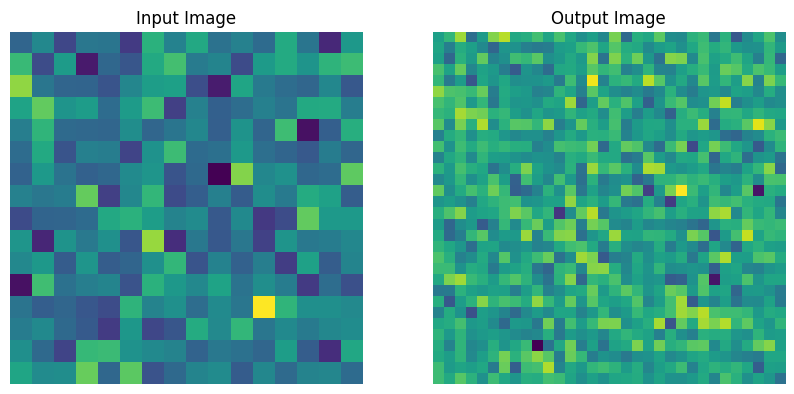

In [ ]:
import torch
import torch.nn as nn

upscale_factor = 2
conv_layer = nn.Conv2d(
    in_channels=1, out_channels=upscale_factor**2, kernel_size=3, padding=1
)

pixel_shuffle = nn.PixelShuffle(upscale_factor)
input_image = torch.randn(1, 1, 16, 16)
output_conv = conv_layer(input_image)
output_image = pixel_shuffle(output_conv)
print("Input image size:", input_image.size())
print("After convolution:", output_conv.size())
print("After pixel shuffle:", output_image.size())

import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(input_image[0][0])
axs[0].set_title("Input Image")
axs[1].imshow(output_image[0][0].detach())
axs[1].set_title("Output Image")
for ax in axs:
    ax.axis("off")
plt.show()

In [ ]:
imshow(input_image[0][0])
axs[0].set_title("Input Image")
axs[1].imshow(output_image[0][0].detach())
axs[1].set_title("Output Image")
for ax in axs:
    ax.axis("off")
plt.show()

# WGan

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

import torch
import torch.nn as nn


class WGANGenerator(nn.Module):
    def __init__(self):
        super(WGANGenerator, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(z_dim, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(True),
            nn.Linear(512, 128 * 7 * 7),
            nn.BatchNorm1d(128 * 7 * 7),
            nn.ReLU(True),
        )
        self.conv = nn.Sequential(
            nn.Conv2d(128, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.PixelShuffle(2),
            nn.Conv2d(8, 8, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.PixelShuffle(2),
            nn.Conv2d(2, 1, kernel_size=3, stride=1, padding=1),
        )

    def forward(self, z):
        z = self.fc(z)
        z = z.view(-1, 128, 7, 7)
        out = self.conv(z)
        return out


class WGANDiscriminator(nn.Module):
    def __init__(self):
        super(WGANDiscriminator, self).__init__()
        self.conv_layer = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Flatten(),
        )
        self.network = nn.Sequential(
            self.conv_layer,
            nn.Linear(64 * 7 * 7, 512),
            nn.Linear(512, 1),
            # nn.Sigmoid(),
        )

    def forward(self, img):
        out = self.network(img)
        return out

In [ ]:
load_from_mem = 1
if load_from_mem:
    wgan_generator = WGANGenerator().to(device)
    wgan_discriminator = WGANDiscriminator().to(device)
else:
    wgan_generator = torch.load("wgan-gen.pt").to(device)
    wgan_discriminator = torch.load("wgan-disc.pt").to(device)

In [ ]:
wgan_training_meta_data = []
wgan_fid_scores = []

In [ ]:
image_size = 28 * 28
batch_size = 512
num_epochs = 150
start = 0
end = num_epochs
step = 20
evaluation_steps = list(range(start, end + 1, step))


def wgan_real_labels(size):
    return torch.ones(size, 1).to(device)


def gen_fake_images(generator, gen_samples):
    noise = torch.randn(gen_samples, z_dim).to(device)
    fake_images = generator(noise)
    return fake_images


def clip_weights(model, lower_bound, upper_bound):
    for param in model.parameters():
        param.data.clamp_(lower_bound, upper_bound)


def wgan_critic_loss(critic_real, critic_fake):
    return torch.mean(critic_fake) - torch.mean(critic_real)

def wgan_generator_loss(critic_fake):
    return -torch.mean(critic_fake)


wgan_d_optimizer = optimizer = optim.RMSprop(
    wgan_discriminator.parameters(), lr=0.001
)
wgan_g_optimizer = optimizer = optim.RMSprop(wgan_generator.parameters(), lr=0.001)

for epoch in range(num_epochs):
    meta_data = {}
    print("Epoch", epoch)
    for batch, (real_images, _) in enumerate(dataloader):
        real_images = real_images.view(-1, 1, 28, 28).to(device)
        batch_size = real_images.size(0)

        # Train Critic
        wgan_d_optimizer.zero_grad()
        real_outputs = wgan_discriminator(real_images.to(device)).to(device)
        z = torch.randn(batch_size, z_dim).to(device)
        fake_images = wgan_generator(z)
        fake_outputs = wgan_discriminator(fake_images.detach())
        d_loss = wgan_critic_loss(real_outputs, fake_outputs)
        d_loss.backward()
        wgan_d_optimizer.step()
        clip_weights(
            wgan_discriminator, -0.01, 0.01
        )  # Clip weights after updating critic

        # Train wgan_Generator
        wgan_g_optimizer.zero_grad()
        fake_images = wgan_generator(z)
        outputs = wgan_discriminator(fake_images)
        g_loss = wgan_generator_loss(outputs)
        g_loss.backward()
        wgan_g_optimizer.step()

        meta_data["d_loss"] = d_loss.item()
        meta_data["g_loss"] = g_loss.item()
        wgan_training_meta_data.append(meta_data)
        pretty_progress(epoch, num_epochs, batch, len(dataloader), d_loss, g_loss)

    print()
    if epoch in evaluation_steps:
        print("Evaluation happens in this epoch")
        generate_and_display_samples(wgan_generator)
        fid_score = some_eval(wgan_discriminator)
        meta_data["fid_score"] = fid_score
        print("FID SCORE : ", fid_score)
        wgan_fid_scores.append(fid_score)

In [ ]:
from pytorch_fid import fid_score
original_fid(wgan_generator, train_data, n=5000)

(5000,)


100%|██████████| 157/157 [00:30<00:00,  5.18it/s]


fid_value: 179.4016569618737


179.4016569618737

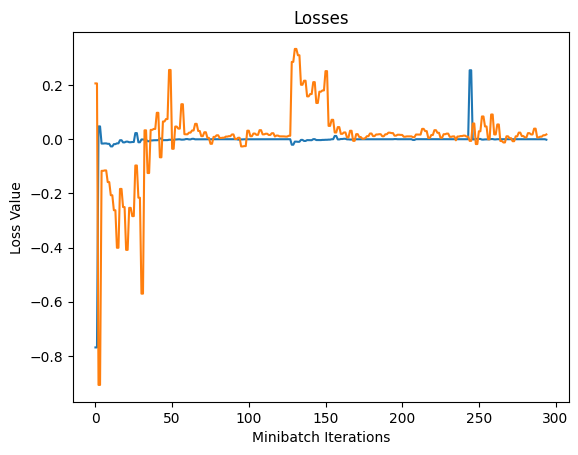

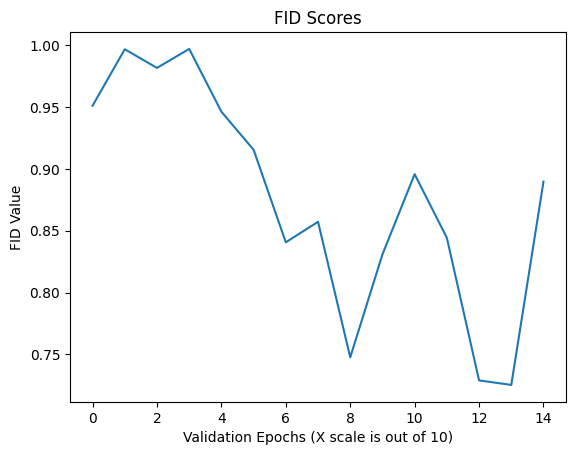

In [ ]:
import matplotlib.pyplot as plt


loss = plt
# Example data

loss.plot(list(map(lambda x: x["d_loss"], wgan_training_meta_data[::30])))
loss.title("Losses")
loss.xlabel("Minibatch Iterations")
loss.ylabel("Loss Value")
loss.plot(list(map(lambda x: x["g_loss"], wgan_training_meta_data[::30])))
loss.title("Losses")
loss.xlabel("Minibatch Iterations")
loss.ylabel("Loss Value")
loss.show()


disc_loss.show()

plt.plot(list(map(lambda x: x, fid_scores)))
plt.title("FID Scores")
plt.xlabel("Validation Epochs (X scale is out of 10)")
plt.ylabel("FID Value")
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import torch


def generate_and_display_samples(generator, num_samples=100, rows=10, cols=10):
    generator.eval()
    with torch.no_grad():
        noise = torch.randn(num_samples, z_dim).to(device)
        fake_images = generator(noise)
        fake_images = fake_images.cpu().detach().numpy()

        fig, axs = plt.subplots(rows, cols, figsize=(10, 10))
        axs = axs.ravel()

        for i in range(num_samples):
            fake_image = fake_images[i].reshape(28, 28)  # Adjust dimensions as needed
            axs[i].imshow(fake_image, cmap="gray")
            axs[i].axis("off")

        plt.subplots_adjust(wspace=0.1, hspace=0.1)
        plt.show()

    generator.train()
    return fake_images

z_dim = 64

In [ ]:
torch.save(wgan_discriminator, "wgan-disc.pt")
torch.save(wgan_generator, "wgan-gen.pt")
torch.save(discriminator, "vanil-disc.pt")
torch.save(generator, "vanil-gen.pt")

In [ ]:
z_dim = 128

In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F

z_dim = 128

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResidualBlock, self).__init__()
        self.block1 = nn.Sequential(
            nn.BatchNorm2d(in_channels),
            nn.ReLU(inplace=False),
            nn.Upsample(scale_factor=2, mode="nearest"),
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=False),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
        )
        self.block2=nn.Sequential(
            nn.Upsample(scale_factor=2, mode="nearest"),
        )

    def forward(self, x):
        return self.block1(x) + self.block2(x)


class SSGANGenerator(nn.Module):
    def __init__(self, z_dim, base_channels=256):
        super(SSGANGenerator, self).__init__()
        self.linear = nn.Linear(z_dim, base_channels * 4 * 4)
        self.residual_blocks = nn.Sequential(
            ResidualBlock(base_channels, base_channels),
            ResidualBlock(base_channels, base_channels),
            ResidualBlock(base_channels, base_channels),
        )
        self.final_layers = nn.Sequential(
            nn.ReLU(inplace=False),
            nn.Conv2d(base_channels, 1, kernel_size=3, stride=1, padding=1),
            nn.Tanh(),
        )

    def forward(self, z):
        out = self.linear(z)
        out = out.view(out.size(0), -1, 4, 4)
        out = self.residual_blocks(out)
        out = self.final_layers(out)
        return out
    
    

In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F

z_dim = 128


def spectral_norm(module, mode=True):
    if mode:
        return nn.utils.spectral_norm(module)
    else:
        return module


class DiscriminatorResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, downsample=True, first_block=False):
        super(DiscriminatorResBlock, self).__init__()
        self.downsample = downsample

        self.block = nn.Sequential(
            nn.ReLU(inplace=False) if first_block else nn.Identity(),
            spectral_norm(nn.Conv2d(in_channels, out_channels, 3, stride=1, padding=1)),
            nn.ReLU(inplace=False),
            spectral_norm(
                nn.Conv2d(out_channels, out_channels, 3, stride=1, padding=1)
            ),
            nn.ReLU(inplace=False) if first_block else nn.Identity(),
        )
        self.bypass = spectral_norm(
            nn.Conv2d(in_channels, out_channels, 1, stride=1, padding=0)
        )
        self.downsampler = (
            nn.AvgPool2d(2, stride=2, padding=1) if downsample else nn.Identity()
        )

    def forward(self, x):
        residual = self.bypass(x)
        x = self.block(x)
        if self.downsample:
            residual = self.downsampler(residual)
            x = self.downsampler(x)
        return x + residual


class SSGANDiscriminator(nn.Module):
    def __init__(self):
        super(SSGANDiscriminator, self).__init__()
        self.initial_channels = 1
        self.res_blocks = nn.Sequential(
            DiscriminatorResBlock(1, 128, downsample=True, first_block=True),
            DiscriminatorResBlock(128, 128, downsample=True, first_block=False),
            DiscriminatorResBlock(128, 128, downsample=False, first_block=False),
            DiscriminatorResBlock(128, 128, downsample=False, first_block=False),
        )
        self.adaptive_pool = nn.AdaptiveMaxPool2d((16, 16))
        self.linear_relu = nn.Sequential(
            nn.ReLU(),
            nn.Dropout(),
            nn.Flatten(),
            nn.Linear(128 * 16 * 16, 128),
            nn.Dropout()            
        )

        self.linear_1 = nn.Sequential(
            nn.Linear(128, 1),
            nn.Sigmoid(),
        )
        self.linear_4 = nn.Sequential(
            nn.Linear(128, 4),
            nn.Softmax(),
        )

    def forward(self, x):
        x = self.res_blocks(x)
        x = self.adaptive_pool(x)
        x = self.linear_relu(x)
        real_or_fake = self.linear_1(x)
        classes = self.linear_4(x)

        return real_or_fake, classes

In [16]:
batch_size = 8

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))
     ]
)

train_data = datasets.MNIST(root="data", train=True, download=True, transform=transform)

train_data = torch.utils.data.Subset(train_data, range(3000))

dataloader = torch.utils.data.DataLoader(
    train_data, batch_size=batch_size, shuffle=True
)
torch.cuda.empty_cache()

In [17]:
noise = torch.randn(1, z_dim).to(device)

In [ ]:
# Create the discriminator
device = "cuda"
# Define hyperparameters
batch_size = 1
lr = 0.001
epochs = 10
image_size = 28
image_channels = 1
latent_dim = 28

ssgan_generator = SSGANGenerator(z_dim)
ssgan_discriminator = SSGANDiscriminator()

ssgan_generator.to(device)
ssgan_discriminator.to(device)
# Loss functions
adversarial_loss = BCEWithLogitsLoss().to(device)
rotation_loss = CrossEntropyLoss().to(device)

# Training loop
for epoch in range(epochs):
    for i, (imgs, _) in enumerate(dataloader):
        real_imgs = imgs.float().to(device)

        # Adversarial ground truths
        valid = torch.ones(imgs.size(0), 1, requires_grad=False).to(device)
        fake = torch.zeros(imgs.size(0), 1, requires_grad=False).to(device)

        # ---------------------
        #  Train Discriminator
        # ---------------------

        ssgan_d_optimizer.zero_grad()

        z = torch.randn(imgs.size(0), z_dim).to(device).float()
        ssgan_generator.float()
        gen_imgs = ssgan_generator(z)

        # Real images
        real_pred, real_aux = ssgan_discriminator(real_imgs)
        d_real_loss = adversarial_loss(real_pred, valid)

        rotated_imgs = real_imgs
        rotated_pred, rotated_aux = ssgan_discriminator(rotated_imgs)
        d_rotated_loss = rotation_loss(
            rotated_aux, torch.ones(imgs.size(0), dtype=torch.long, device=device)
        )

        # Fake images
        fake_pred, _ = ssgan_discriminator(gen_imgs.detach())
        d_fake_loss = adversarial_loss(fake_pred, fake)

        # Total discriminator loss
        d_loss = (
            d_real_loss
            +
            #   + d_rotated_loss +
            d_fake_loss
        ) / 3
        d_loss.backward()
        ssgan_d_optimizer.step()

        # -----------------
        #  Train Generator
        # -----------------

        ssgan_d_optimizer.zero_grad()

        # Generate a batch of images
        fake_pred, _ = ssgan_discriminator(gen_imgs)

        g_loss = adversarial_loss(fake_pred, valid)

        g_loss.backward()
        ssgan_d_optimizer.step()

        print(
            "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
            % (epoch, epochs, i, len(dataloader), d_loss.item(), g_loss.item())
        )

# Save the model checkpoints

In [ ]:
from matplotlib import plt
fig, axs = plt.subplots(1, 1, figsize=(10, 5))
axs.imshow(ssgan_generator(noise)[0][0].detach().cpu(),cmap='gray')